# Turial : Conditional Neural Processes - 1D GP Data

Last Update : 11 June 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See the docstrings of `GPDataset` for more details. 

**Details**
- 1 D inputs (x) and outputs (y)
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)), with hyperparameters from [sklearn examples](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py): 
    - Squared Exponential
    - Matern
    - Exp-Sine-Squared (periodic)
    - Dot-Product (non-stationary and invariant to rotation around origin). 
- Points are sampled between (-5, 5) but scaled in (-1,1) as for inputs to the model (worked just as well without rescaling but slighlty easier to code for more advance things).
- At every epoch we precompute all the sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled functions for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the datset for one epoch.

**Extensions**

- Adding a dataset from a new kernel is straightforward by definining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).
- TO-DO : add a function to sample extrapolation points

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
NUM_POINTS = 128
NUM_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(num_samples=NUM_SAMPLES, num_points=NUM_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

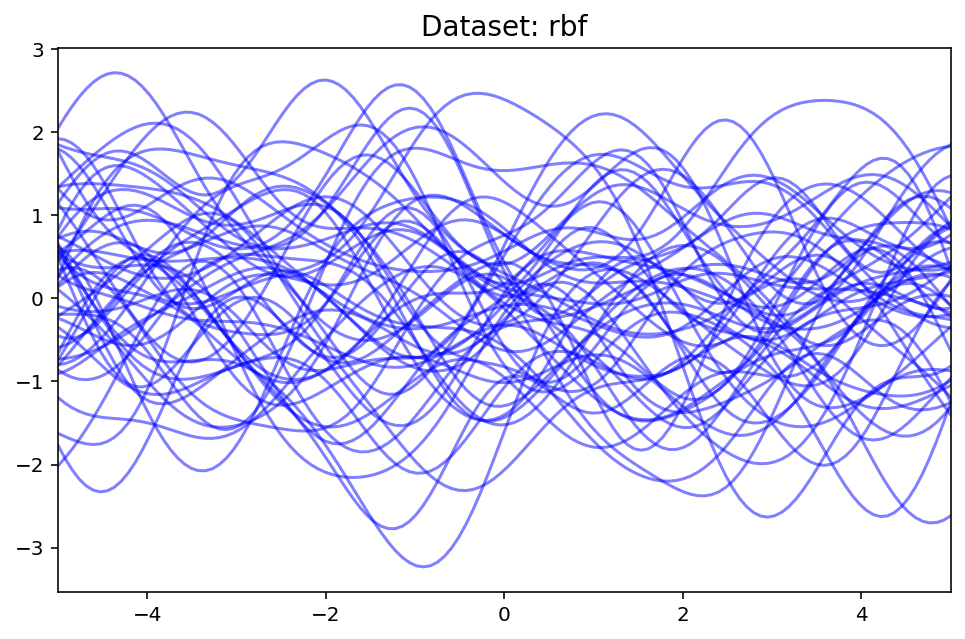

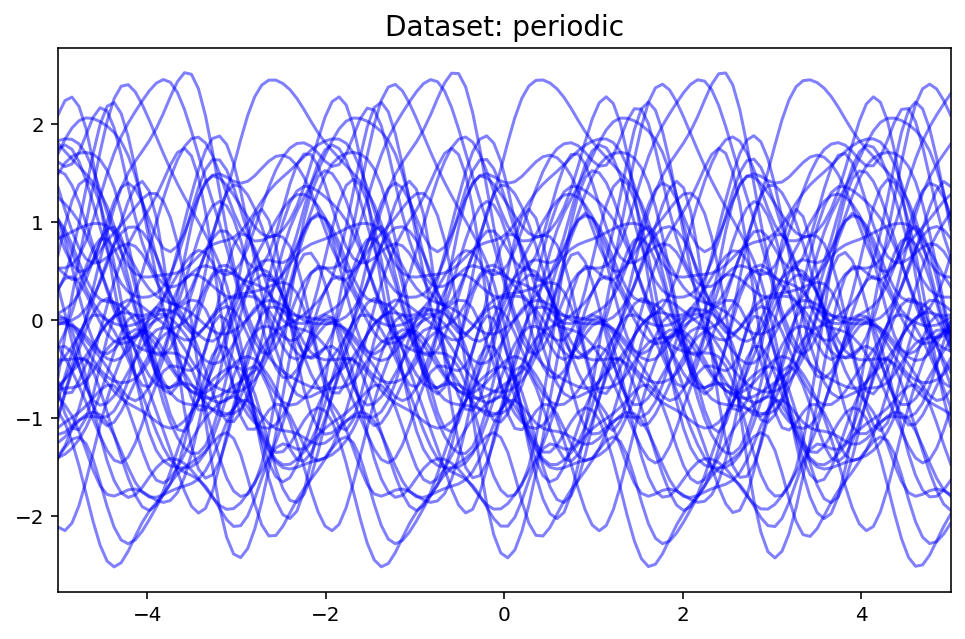

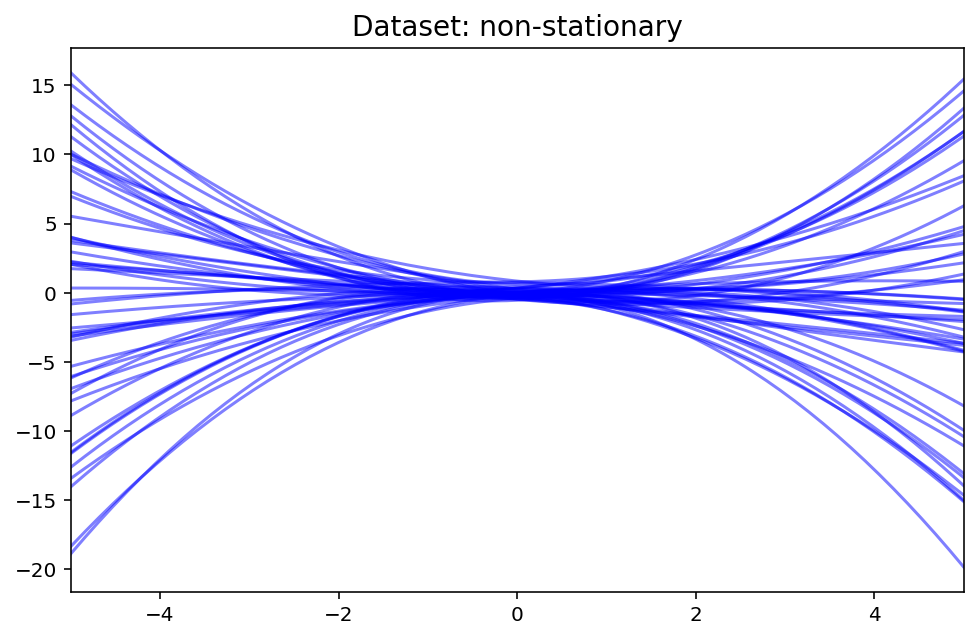

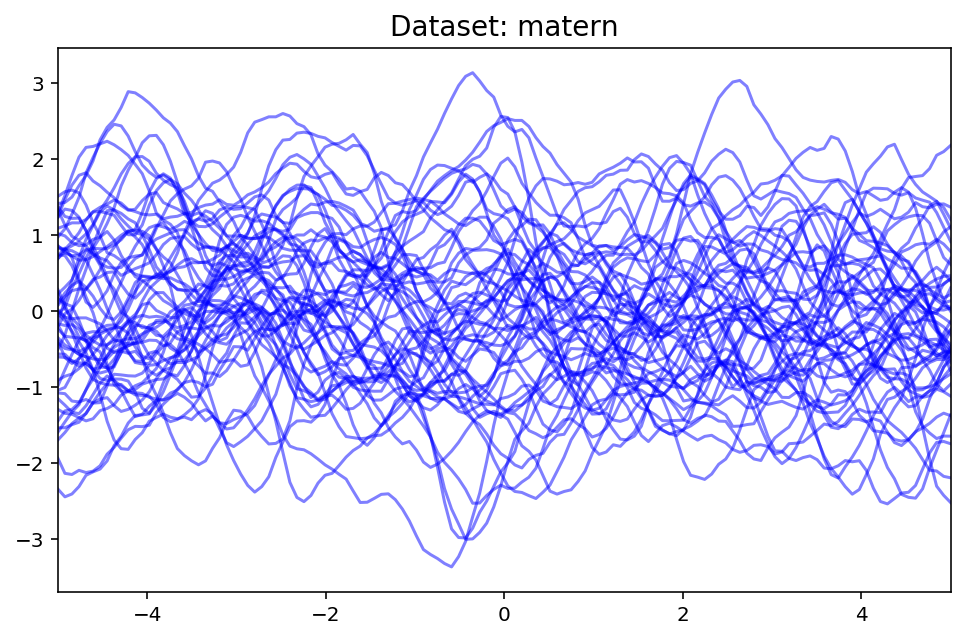

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. See the docstrings of `NeuralProcess` for more details. 


Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension of hidden representation.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
    - `Identity` : this is what they use in the paper but it doesn't work as well
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `add_flat_input(MLP)` : learn representation with MLP (`add_flat_input` changes the constructor generaltity / compatibility)
    - `SelfAttentionBlock` : self attention mechanisms (as [Attentive Neural Process][anp]). For more parameters (attention type, number of layers ...) refer to its docstrings.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `add_flat_input(MLP)` : predict with MLP.
    - `SelfAttentionBlock` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process][anp], but in [image transformer][im transf]). 
- `aggregator` : Agregreator function which maps $\{r_i\} \to r$. To use a cross attention aggregation, use `AttentiveNeuralProcess` instead of `NeuralProcess`.
- `get_cntxt_trgt` :  Function that split the input into context and target points. Note: context points should be a subset of target ones.
- `PredicitiveDistribution` : Predictive distribution, e.g. `Normal`, `Laplace`, ....


**Additional Parameters : (Attentive) Neural Process**

- `encoded_path` : Which path(s) to use:
    - `"deterministic"` uses a [Conditional Neural Process][cnp] (no latents), where the decoder gets a deterministic representation as input (function of the context). 
    - `"latent"` uses a [Neural Process][np], where the decoder gets a sample latent representation as input (function of the target during training and context during test).
    - If `"both"` concatenates both representations as described in [Attentive Neural Process][anp].
- `LatentEncoder` : Encoder which maps $r \to [\mu_z; f(\sigma_z)]$. Only used if `encoded_path` in `["latent", "both"]`.

To use cross-attention instead of aggregation (i.e. [Attentive Neural Process][anp]) replace `NeuralProcess` with `AttentiveNeuralProcess`. Many different attention mechanisms are available (image transformer, multihead, dot head, manhattan ...), see its docstrings for more details. 
    

**Extensions**

- For Neural Process, see the [Tutorial - Neural Process][np tuto] notebook.
- For Attentive Neural Process, see the [Tutorial - Attentive Neural Process][anp tuto] notebook.
- Bayesian Hyperparameter Optimization is easy to run as the library is a wrapper around sklearn. To do so use `BayesSearchCV` from `skopt` which is in *requirements.txt* ([example](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html))

[np]: https://arxiv.org/abs/1807.01622
[cnp]: https://arxiv.org/pdf/1807.01613.pdf
[anp]: https://arxiv.org/abs/1901.05761
[im transf]: https://arxiv.org/abs/1802.05751
[np tuto]: Tutorial%20-%20Neural%20Process.ipynb
[anp tuto]: Tutorial%20-%20Attentive%20Neural%20Process.ipynb

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, add_flat_input, DeepMLP
from skssl.transformers.neuralproc.datasplit import context_target_split

In [9]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, NUM_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [10]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # encoding X (not done in the paper) improves the results
                         XYEncoder=add_flat_input(DeepMLP),  # no self attention encoder (3 hidden layer MLP)
                         Decoder=add_flat_input(DeepMLP), # no self attention decoder (3 hidden layer MLP)
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredicitiveDistribution=Normal, # Gaussian predictive distribution
                         encoded_path="deterministic") # use CNP

In [11]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [12]:
from utils.helpers import count_parameters

In [13]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 136642


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

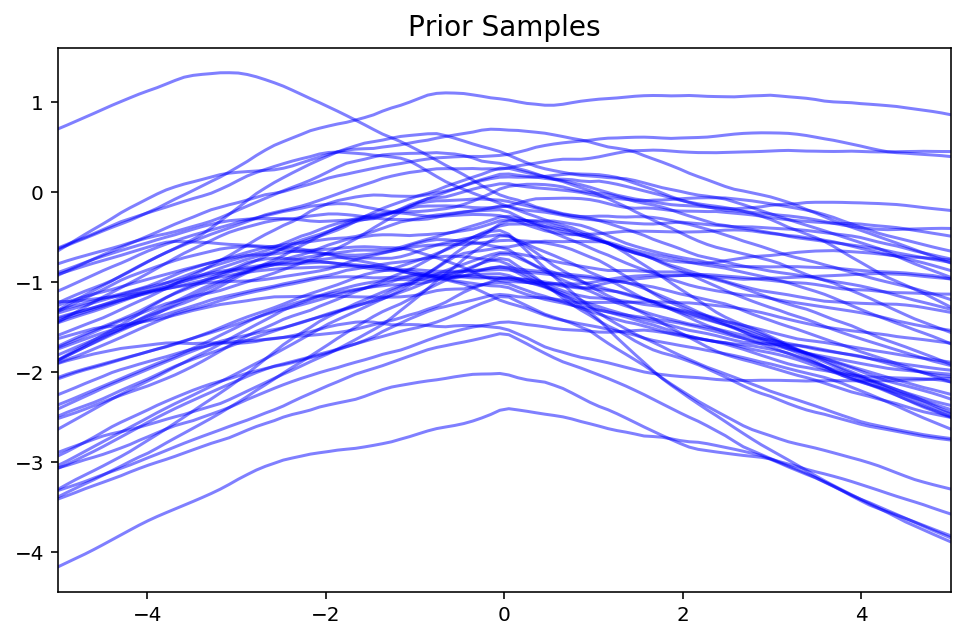

In [14]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, R_DIM, min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

In [15]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

In [16]:
N_EPOCHS = 30
# small batch size good to have different sizes of context / target
# but too smal becomes very slow (they use 16)
BATCH_SIZE = 64
is_RETRAIN = False # if false load precomputed

In [17]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 but don't want to train too long and we use larger batch
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      120.7377     +  13.5371


      2       74.6805     +  14.6670


      3       45.7215     +  13.3981


      4       27.7632     +  13.6951


      5       12.1310     +  13.4358


      6        1.8505     +  13.3249


      7       -7.1877     +  14.3223


      8      -15.2175     +  14.0040


      9      -20.1502     +  12.6244


     10      -22.1813     +  13.4335


     11      -29.5328     +  12.1321


     12      -35.1937     +  13.9329


     13      -38.4602     +  13.6578


     14      -38.6585     +  13.7132


     15      -42.2383     +  13.8932


     16      -47.6959     +  12.5817


     17      -49.8669     +  13.0094


     18      -50.5136     +  13.8650


     19      -51.3443     +  12.9754


     20      -52.6713     +  13.8714


     21      -54.0968     +  14.2761


     22      -53.8794        14.3563


     23      -57.8196     +  13.6708


     24      -57.5431        13.9881


     25      -63.4429     +  14.4823


     26      -61.8870        13.3397


     27      -61.7138        13.5731


     28      -60.3217        12.7039


     29      -62.9899        11.5255


     30      -67.0610     +  13.9957

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      137.0075     +  17.2567


      2      117.1816     +  17.4422


      3       83.6760     +  16.7577


      4       68.7949     +  16.8778


      5       52.0336     +  17.6639


      6       35.0100     +  16.9271


      7       22.8692     +  16.4233


      8       12.8247     +  17.2373


      9        7.7224     +  16.4589


     10        5.1245     +  16.9257


     11       -1.0033     +  16.5918


     12      -10.7134     +  17.6534


     13      -16.3631     +  17.0111


     14      -20.8070     +  16.7450


     15      -26.4631     +  16.6703


     16      -29.9320     +  16.9347


     17      -34.9947     +  17.4767


     18      -36.3657     +  17.3634


     19      -38.6111     +  17.2327


     20      -43.0702     +  16.7252


     21      -45.5587     +  17.1873


     22      -49.4175     +  16.9821


     23      -51.7908     +  17.1506


     24      -53.3720     +  17.4147


     25      -57.3969     +  16.6805


     26      -57.5951     +  16.8646


     27      -57.9209     +  17.4338


     28      -58.7464     +  16.8622


     29      -61.4611     +  16.2777


     30      -65.2583     +  17.3958

--- Training non-stationary ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      109.1833     +  17.2762


      2       13.6654     +  16.9932


      3      -24.5281     +  17.5542


      4      -42.7721     +  16.7506


      5      -56.3013     +  17.4472


      6      -68.0026     +  17.1513


      7      -71.7030     +  17.2191


      8      -81.9007     +  17.1737


      9      -85.3123     +  16.3982


     10      -88.8195     +  17.3687


     11      -94.1836     +  16.4662


     12      -99.2017     +  16.8687


     13     -102.8523     +  17.3929


     14     -102.2951        17.2890


     15     -100.2928        17.2617


     16     -105.0503     +  16.2501


     17     -107.2281     +  17.2464


     18     -108.8853     +  17.2182


     19     -110.5926     +  16.6315


     20     -109.7472        17.1052


     21     -112.1631     +  17.0966


     22     -115.7742     +  16.7692


     23     -113.7576        17.1837


     24     -116.2788     +  16.6004


     25     -116.5090     +  16.6585


     26     -118.0204     +  17.3706


     27     -117.3588        17.2174


     28     -117.2790        17.2856


     29     -120.2228     +  16.9133


     30     -120.6853     +  17.0913

--- Training matern ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      129.9796     +  17.2994


      2      100.3302     +  16.9077


      3       84.2412     +  17.0439


      4       73.1515     +  16.4654


      5       63.3692     +  16.5513


      6       57.5984     +  17.2714


      7       52.4653     +  16.8696


      8       46.4562     +  16.1730


      9       43.1850     +  17.3222


     10       41.9060     +  17.0180


     11       37.6396     +  16.3728


     12       33.1272     +  17.1205


     13       31.8065     +  17.4733


     14       30.5872     +  17.3974


     15       28.1334     +  16.6921


     16       25.1160     +  16.7294


     17       22.5691     +  17.2885


     18       22.5796        17.3033


     19       22.5086     +  16.2149


     20       20.5743     +  16.9528


     21       19.8683     +  16.6832


     22       19.5251     +  16.6585


     23       17.4985     +  17.1519


     24       16.9248     +  17.1153


     25       13.0714     +  17.0829


     26       14.0421        16.8307


     27       13.5354        17.5099


     28       14.2935        16.9121


     29       12.3046     +  17.7786


     30        9.5746     +  16.9713


In [33]:
data_models2

In [ ]:
for k,(neural_proc, dataset) in data_models2.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 but don't want to train too long and we use larger batch
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    else:
        

# Inference

## Trained Prior

The prior should now encode some information about the shapes of the functions. Neural processes can be thought of methods that learn a kernel functions from the data, if they are effective teh trained prior should thus be very similar to the the samples the datasets previously seen.

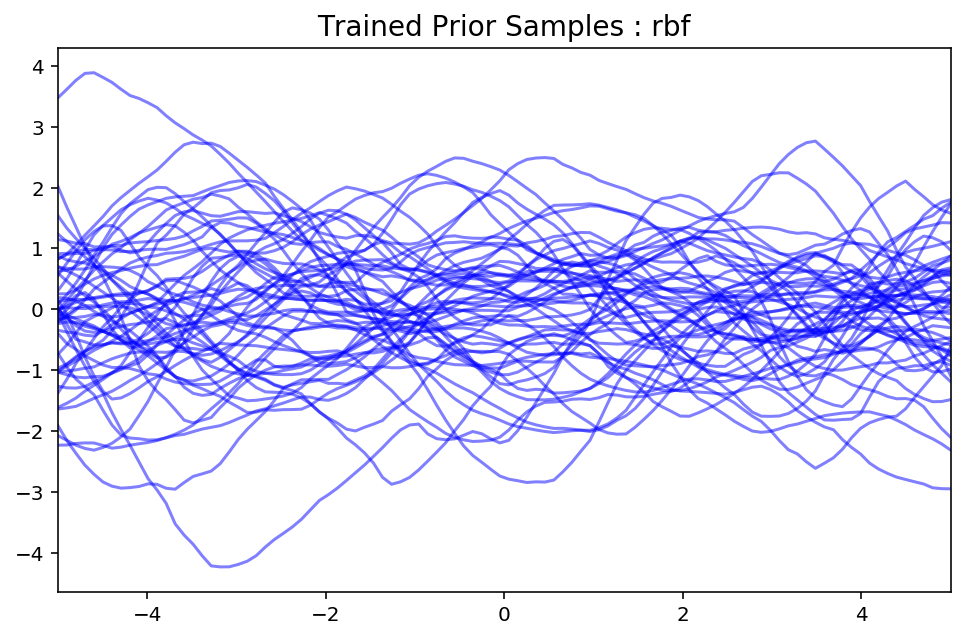

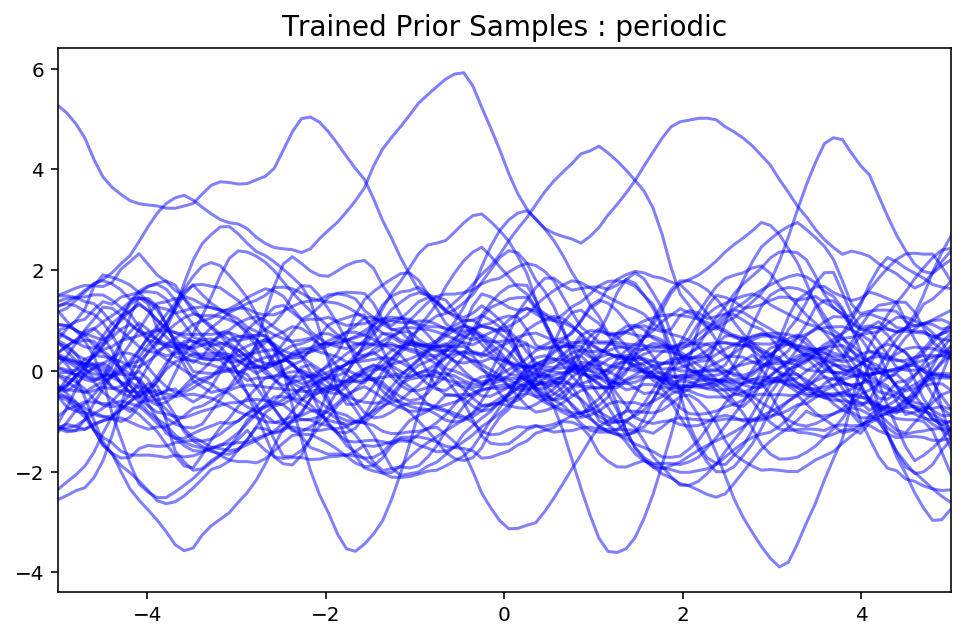

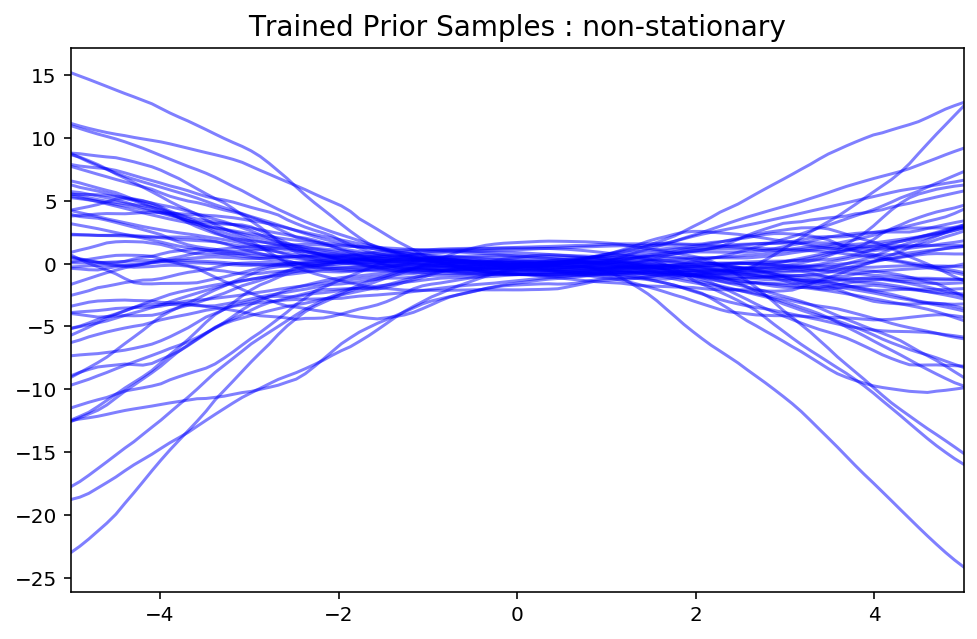

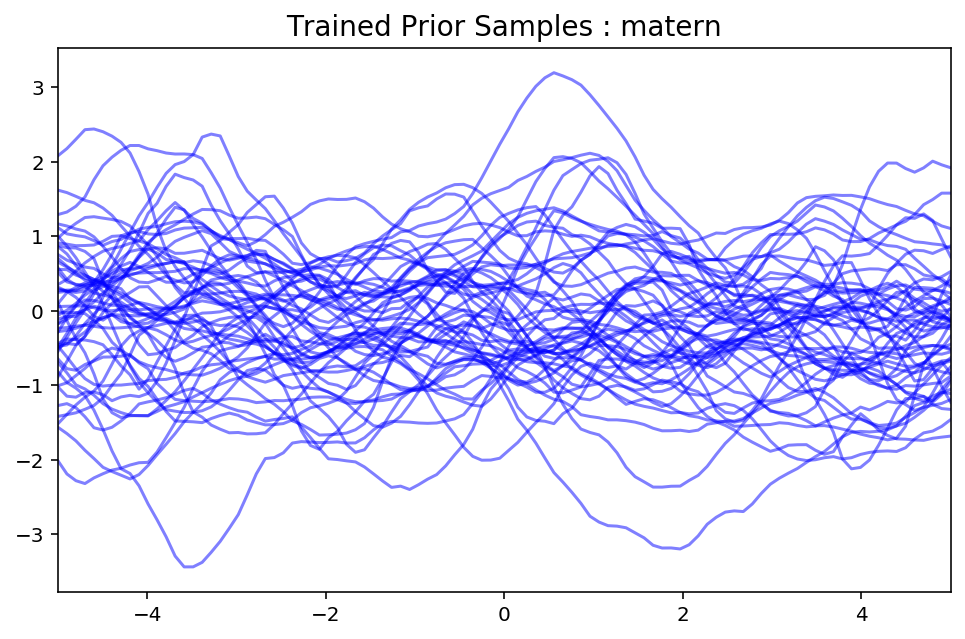

In [18]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, R_DIM, 
                       title="Trained Prior Samples : {}".format(k), 
                       min_max=dataset.min_max)

We see that the trained priors are not too bad but cannot learn very smooth samples (e.g. for all besides Matern).

## Posterior

Let us now investigate the posterior over functions when conditioned on some new context points.

std: 0.23844466
std: 0.23555179
std: 0.5513661
std: 0.67703897


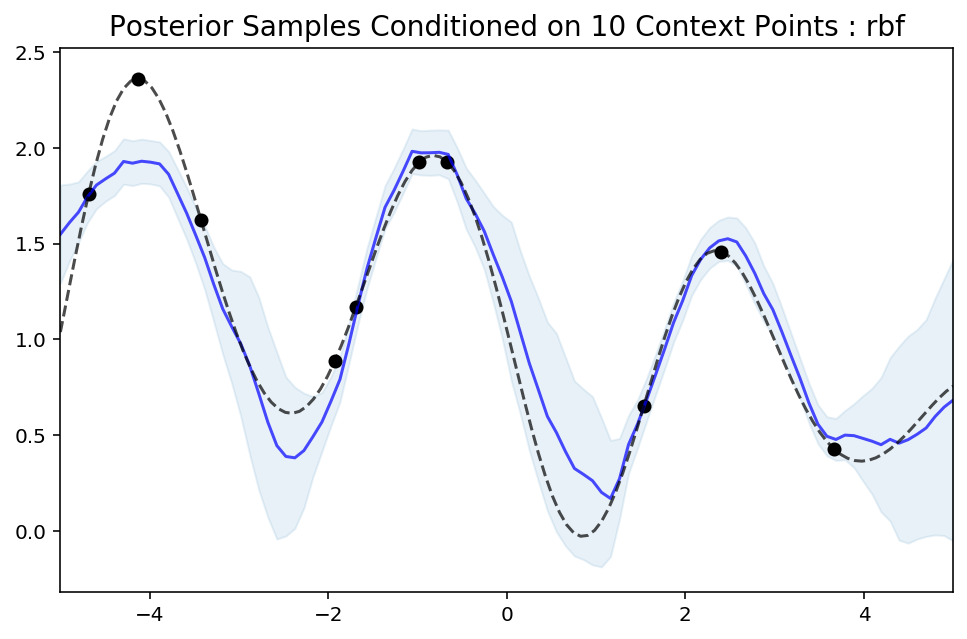

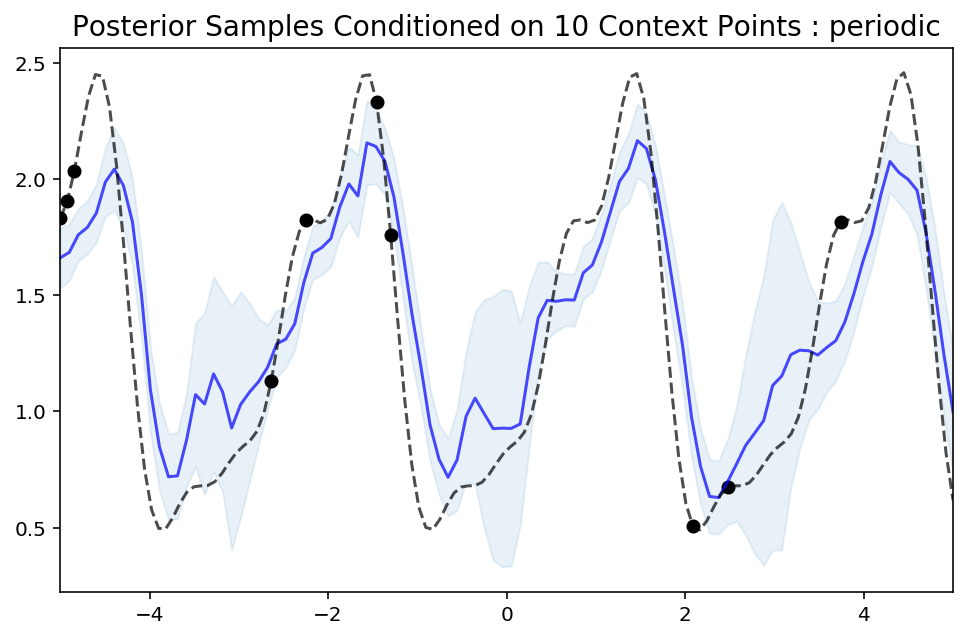

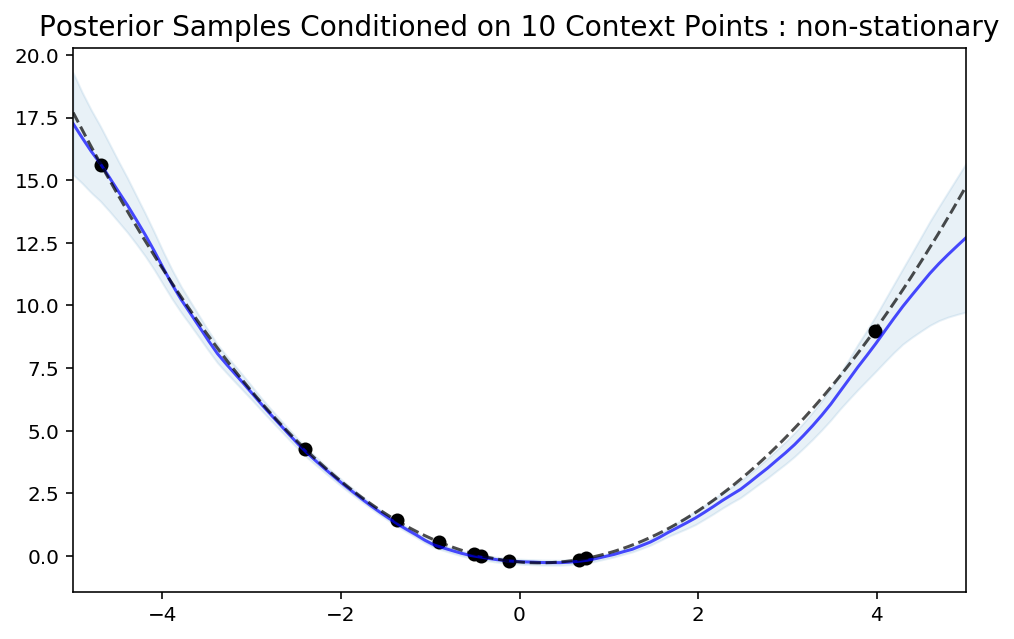

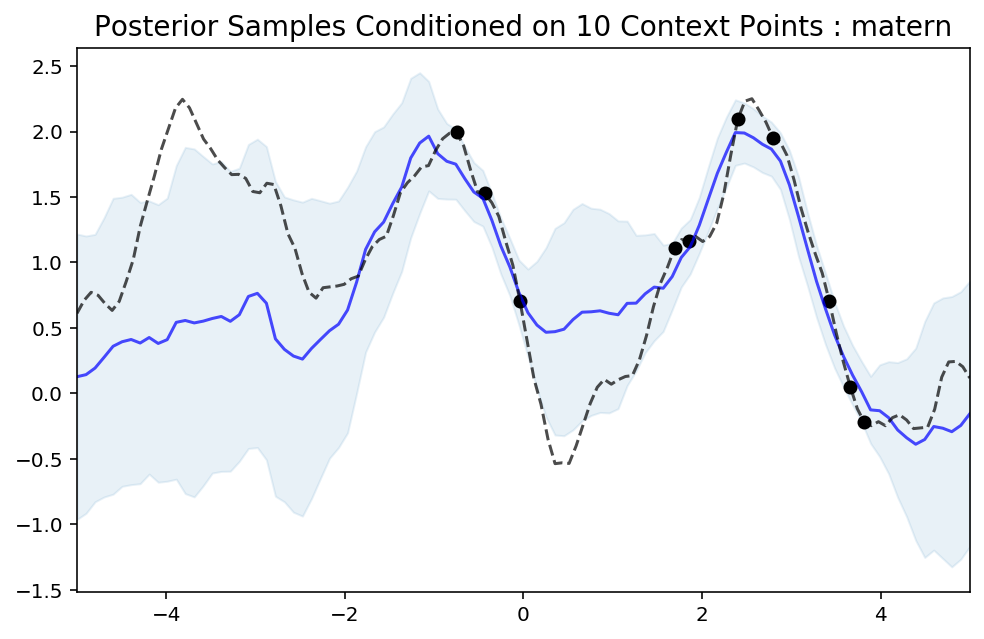

In [29]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(n_cntxt, k))

To have a better understanding of uncertainty let's look at only 2 context points:

std: 0.8808435
std: 0.5884818
std: 1.3116037
std: 1.0045474


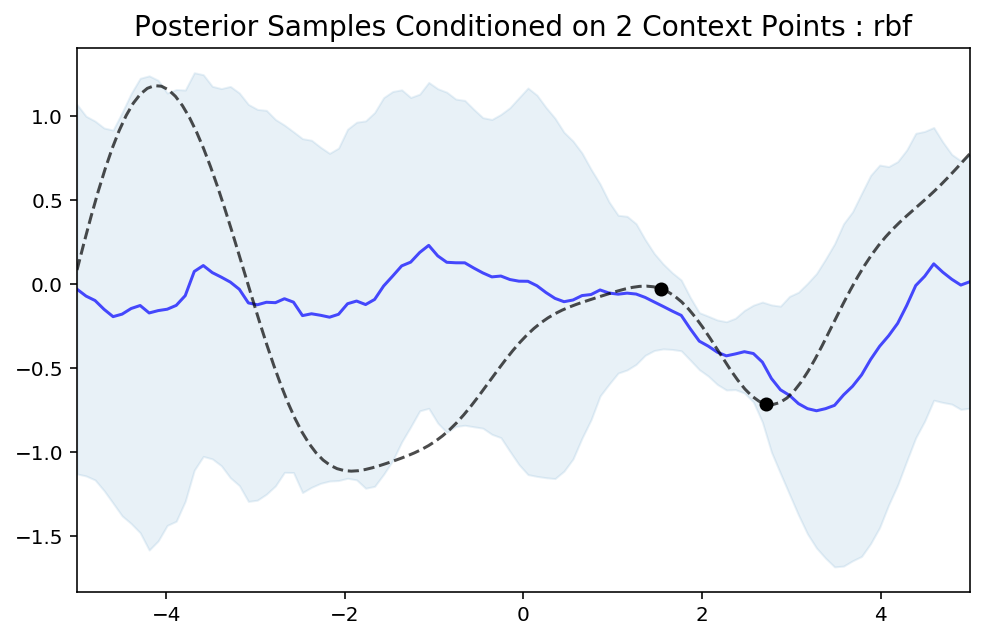

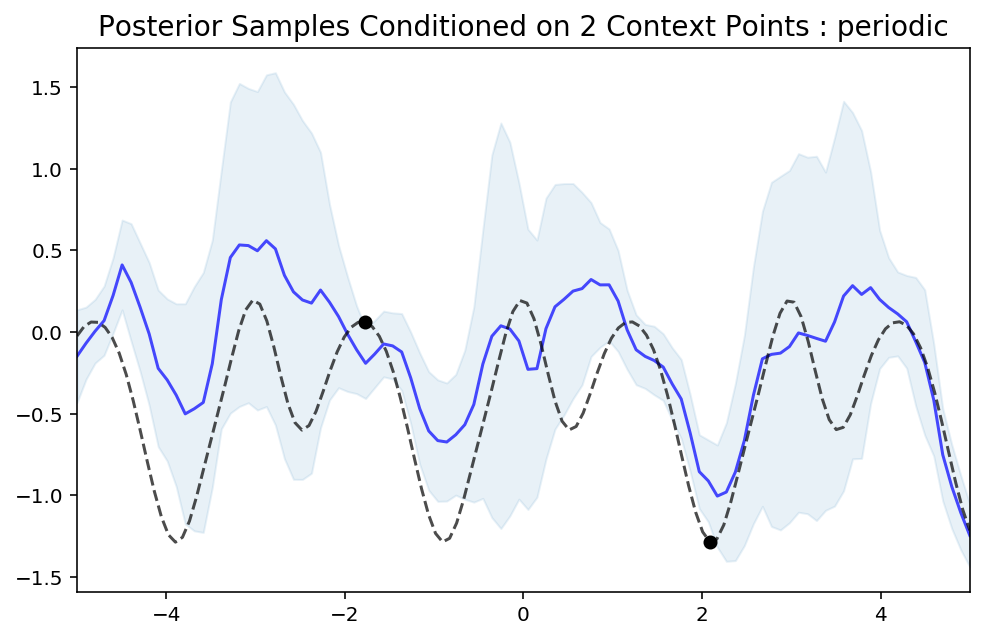

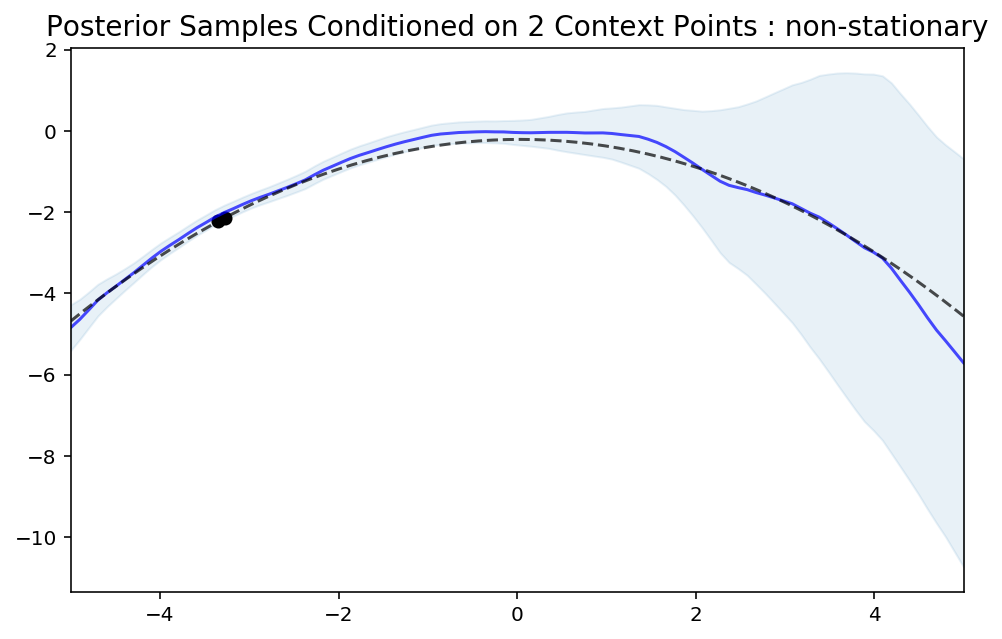

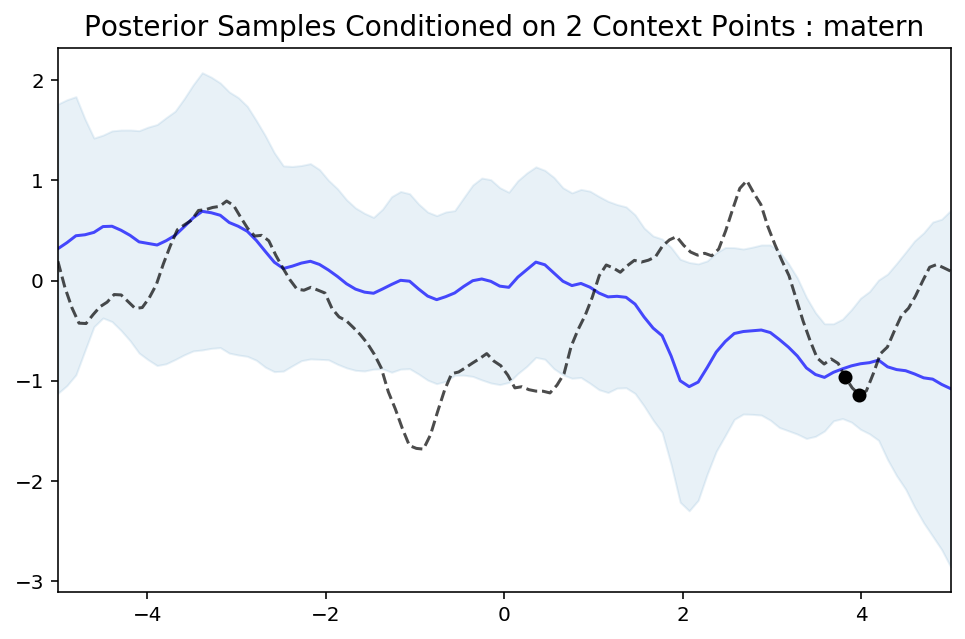

In [31]:
n_cntxt = 2

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(n_cntxt, k))

We see that the predictions are not too bad.

**Good**:
- The standard devation does not collapse to the minimum value it can output (i.e. 0.1). It is also relatively uncertain far from context points.

**Bad**:
- it often underfits and the mean does not often pass through the context points (and the variance doesn't decrease at those points).